<a href="https://colab.research.google.com/github/sv-kopylov/predictor/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорты и подключение диска

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import keras
from keras.utils import np_utils #Для to_categorical
import numpy as np #Numpy
from keras.optimizers import adam_v2 #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Функции



In [3]:
# Приведение ответа к 1 или -1 или 0
def toY(dif, treshold):
  if(dif==0):
    return 0
  if(abs(dif)<=treshold):
    return 0
  if(dif>0):
    return 1
  else:
    return -1

# Приведение объема торгов к значению относительно среднего для всех тикеров
def normaliseAllVolumesByMean(df):
  tickers_array = base_data['TICKER'].unique()
  for tic in tickers_array:
    normalizeVolume(df, tic)
  
# Приведение объема торгов к значению относительно среднего для одного тикера
def normalizeVolume(df, ticker):
  mask = df['TICKER']==ticker
  delim = df[mask]['VOLUME'].mean()
  df.loc[mask, 'VOLUME'] = df[mask]['VOLUME']/delim


# Разбиение одного тикера на окна
## небольшая справка - при преобразовании теряется длина 2 * frameLen одна на начале последовательноти (где нет ответов), 
## вторая на разрыве между тестовой и проверочной
def toTrainingOneTicker(df, ticker, frameLen, X_train, Y_train, X_test, Y_test):
  resultX = [] # для промежуточных результатов x
  resultY = [] # для промежуточных результатов y

  # сначала заполняем промежуточные результаты
  mask = df['TICKER']==ticker
  newDF = df[mask]
  total = len(newDF)
  for i in range(0, total-frameLen): # с учетом длины рамки и того, что индексация начинается с 0, итерируемся до предпоследнего значения
    resultX.append(toTrainMatrix(newDF, i, frameLen))
    resultY.append(newDF.iloc[i+frameLen,8])
  
  # теперь разделяем на тренировочную и проверочную и добавляем в мастер-массивы
  total = len(resultX)
  border = int(total*TEST_DATA_PART)
  X_train.extend(resultX[0:total-border])
  Y_train.extend(resultY[0:total-border])

  X_test.extend(resultX[total-border+frameLen:])
  Y_test.extend(resultY[total-border+frameLen:])


# # Преобразование строк по длине окна
def toTrainMatrix(df, start, frameLen): # start включительно, start + frameLen не включается
  result = []
  for n in range(start, start+frameLen):
    result.append(toTrainString(df, n))
  return result

# преобразование одной строки
def toTrainString(df, str):
  result = []
  result.append(df.iloc[str, 3]) # MAX
  result.append(df.iloc[str, 4]) # MIN
  result.append(df.iloc[str, 5]) # CLOSE
  result.append(df.iloc[str, 6]) # VOLUME
  result.extend(df.iloc[str, 9])
  return result




## Константы, чтение и преобразование данных

In [4]:
TRASHOLD = 0.004 # комиссия за зделку, меньше которой шевелиться будет себе дороже
TEST_DATA_PART = 0.1 # процент на тестовую выборку

#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/MyDrive/datas/all.csv')
# приводим дату и время к нужному формату
base_data['DATE_TIME'] = pd.to_datetime(base_data['DATE_TIME'], format = '%Y-%m-%d %H:%M:%S')
# сортируем по тикеру и дате
base_data.sort_values(['TICKER', 'DATE_TIME'], inplace=True )

# добавляем колонку с разницей
base_data['DIFF'] = base_data['CLOSE'] - base_data['OPEN']

# нормализуем все по открытию
base_data['MAX'] = base_data['MAX']/base_data['OPEN']
base_data['MIN'] = base_data['MIN']/base_data['OPEN']
base_data['CLOSE'] = base_data['CLOSE']/base_data['OPEN']
base_data['DIFF'] = base_data['DIFF']/base_data['OPEN']

# Добавляем колонку с правильными ответами
base_data['Y'] = base_data['DIFF'].apply(lambda x: toY(x, TRASHOLD))

# нормализуем объемы по среднему значению для каждого тикера
normaliseAllVolumesByMean(base_data)

# Получаем словарь тикеров
tickers_array = base_data['TICKER'].unique()
TICKERS_DICT = {tickers_array[x]:x for x in range(0, len(tickers_array))}

# Переводим тикеры в категории
 # пример разбиения
 # tst = [x for x in range(0,24)]
 # a = np_utils.to_categorical(tst,24)

base_data['CAT']=base_data['TICKER'].apply(lambda x: np_utils.to_categorical(TICKERS_DICT[x], len(tickers_array)))

# Создаем массивы для тренировочных и проверочных данных
X_train = []
Y_train = []
X_test = []
Y_test = []

# Заполняем массивы тренировочных и проверочных данных
for tic in tickers_array:
  toTrainingOneTicker(base_data, tic, 5, X_train, Y_train, X_test, Y_test)


In [56]:
arr = np.array(X_train)
arr.shape

(3935, 5, 28)

## Отрисовка

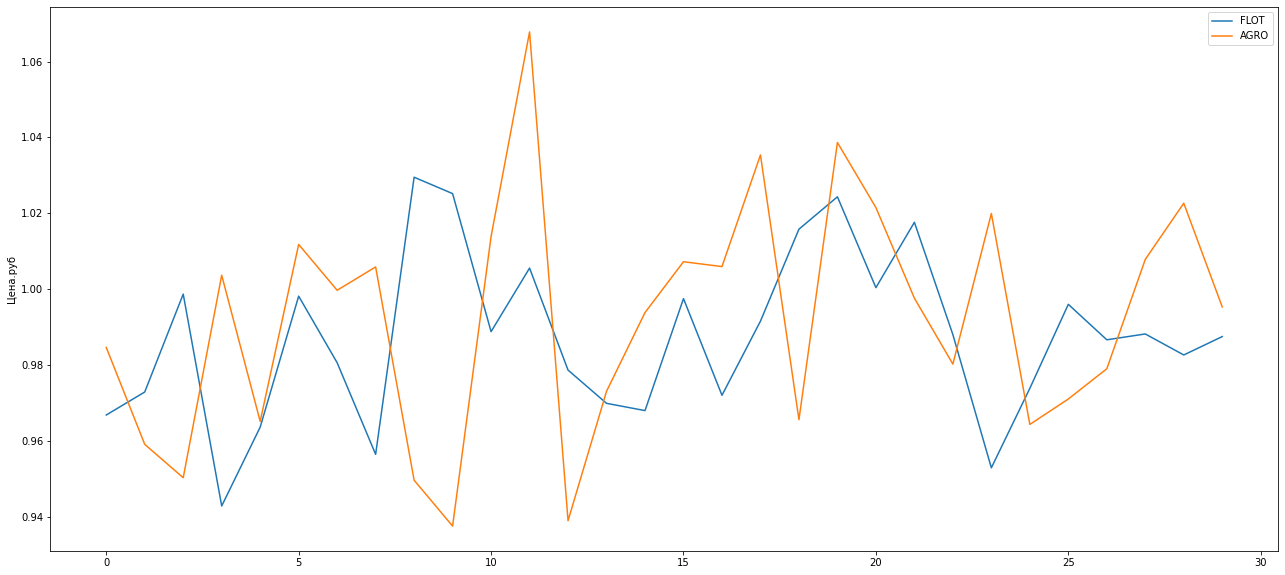

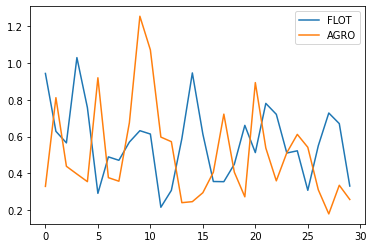

In [52]:
#Заполняем текстовые названия каналов данных
chanelNames = ['FLOT', 'AGRO']#, 'YNDX', 'FLOT', 'NLMK']
start =120 
frame = 30

#Рисуем все графики данных
#Четыре основных канала - open, max, min, close

plt.figure(figsize=(22, 10))
for ticker in chanelNames:
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  toDraw = base_data['CLOSE'][base_data['TICKER']==ticker].values
  plt.plot(toDraw[start:start+frame], 
          label=ticker)
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
for ticker in chanelNames:
  toDraw = base_data['VOLUME'][base_data['TICKER']==ticker].values
  plt.plot(toDraw[start:start+frame], 
          label=ticker)
plt.legend()
plt.show()

## Сеть

In [27]:
model = keras.Sequential()
model.add(Dense(1024, activation="relu", input_shape=(5,28)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(2, activation="sigmoid"))


In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 5, 1024)           29696     
                                                                 
 flatten_4 (Flatten)         (None, 5120)              0         
                                                                 
 dense_13 (Dense)            (None, 128)               655488    
                                                                 
 dense_14 (Dense)            (None, 2)                 258       
                                                                 
Total params: 685,442
Trainable params: 685,442
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss="binary_crossentropy", optimizer=adam_v2.Adam(learning_rate=1e-4), metrics=["accuracy"])

In [8]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [20]:
Y_train.shape

(3935,)

In [25]:
def copy2binary(y):
  resp = np.zeros((len(y),2))
  for i in range(len(y)):
    if(y[i]>0):
      resp[i,0]=1
    else:
      resp[i,1]=1
  return resp


Y_train_bin = copy2binary(Y_train)
Y_test_bin = copy2binary(Y_test)
print(Y_train_bin.shape)
print(Y_test_bin.shape)

(3935, 2)
(311, 2)


In [32]:
history = model.fit(X_train, 
                    Y_train_bin, 
                    batch_size=100, 
                    epochs=200,
                    validation_data=(X_test, Y_test_bin),
                    verbose=1)

Epoch 1/200
40/40 [==============================] - 1s 24ms/step - loss: 0.2590 - accuracy: 0.8920 - val_loss: 1.3285 - val_accuracy: 0.5659
Epoch 2/200
40/40 [==============================] - 1s 21ms/step - loss: 0.2362 - accuracy: 0.9037 - val_loss: 1.3616 - val_accuracy: 0.5916
Epoch 3/200
40/40 [==============================] - 1s 21ms/step - loss: 0.2391 - accuracy: 0.8999 - val_loss: 1.4073 - val_accuracy: 0.5756
Epoch 4/200
40/40 [==============================] - 1s 21ms/step - loss: 0.2389 - accuracy: 0.9042 - val_loss: 1.3490 - val_accuracy: 0.5498
Epoch 5/200
40/40 [==============================] - 1s 22ms/step - loss: 0.2324 - accuracy: 0.9057 - val_loss: 1.3568 - val_accuracy: 0.5788
Epoch 6/200
40/40 [==============================] - 1s 21ms/step - loss: 0.2346 - accuracy: 0.9075 - val_loss: 1.3786 - val_accuracy: 0.5498
Epoch 7/200
40/40 [==============================] - 1s 22ms/step - loss: 0.2378 - accuracy: 0.9009 - val_loss: 1.3862 - val_accuracy: 0.6045
Epoch 

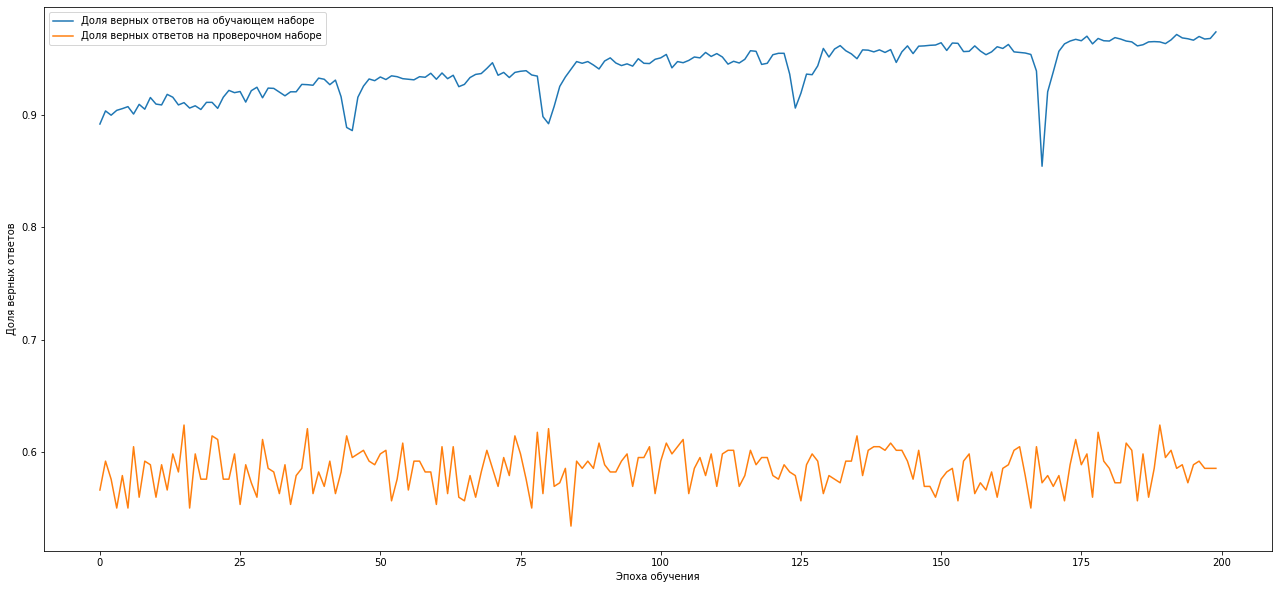

In [34]:
#Отображаем график точности обучения
plt.figure(figsize=(22, 10))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()